In [1]:
%load_ext autoreload
%load_ext line_profiler
import sys
sys.path.append("..")

In [48]:
%autoreload

import numpy as np
import pickle

import main


import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc_file('matplotlibrc')

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.spectools as spectools

from darkhistory.spec.spectrum import Spectrum

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.elec_cooling import get_elec_cooling_tf_fast

from darkhistory.electrons import positronium

from scipy.interpolate import interp1d


# Marching Up Algorithm

In [3]:
ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf = main.load_ics_data()


********* Thomson regime scattered photon spectrum *********
Initializing...
Computing spectra by an expansion in beta...
----> Computation by expansion in beta complete!
Computing spectra by analytic series...
*** Computing series 1/12...
*** Computing series 2/12...
*** Computing series 3/12...
*** Computing series 4/12...
*** Computing series 5/12...
*** Computing series 6/12...
*** Computing series 7/12...
*** Computing series 8/12...
*** Computing series 9/12...
*** Computing series 10/12...
*** Computing series 11/12...
*** Computing series 12/12...
----> Computation by analytic series complete!
Spectrum computed!
********* Relativistic regime scattered photon spectrum *********
Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!
********* Thomson regime energy loss spectrum *********
Computing nonrelativistic energy loss spectrum...
Computing energy loss spectrum by beta expansion...
C

In [252]:
# pickle.dump(ics_thomson_ref_tf, open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_thomson_ref_tf.raw", "wb"))
# pickle.dump(ics_rel_ref_tf, open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_rel_ref_tf.raw", "wb"))
# pickle.dump(engloss_ref_tf, open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/engloss_ref_tf.raw", "wb"))

In [4]:
ics_thomson_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_thomson_ref_tf.raw", "rb")) 
ics_rel_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_rel_ref_tf.raw", "rb"))
engloss_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/engloss_ref_tf.raw", "rb"))

In [123]:
%autoreload

eleceng = 10**np.arange(0, np.log10(5e12), 0.0254)
photeng = 10**np.arange(-4, np.log10(5e12), 0.0334)


rs = 600
xe = 1e-2

from darkhistory.spec.spectra import Spectra

%lprun -f spectools.engloss_rebin_fast -f get_elec_cooling_tf_fast get_elec_cooling_tf_fast(ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf,eleceng, photeng, rs, xe, xHe=0, check_conservation_eng=True, verbose=False)



../darkhistory/spec/spectra.py:401: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(type(other), float)
../darkhistory/spec/spectra.py:402: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  or np.issubdtype(type(other), int)


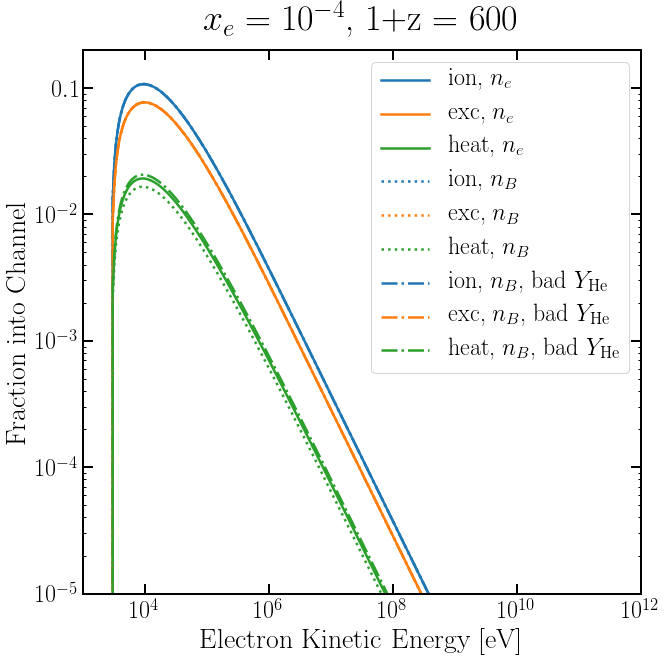

In [25]:
plt.figure()

ax = plt.gca()
ax.loglog()

plt.xlabel('Electron Kinetic Energy [eV]')
plt.ylabel('Fraction into Channel')
plt.title(r'$x_e = 10^{-4}$, 1+z = 600')

plt.axis([1e3, 1e12, 1e-5, 0.2])

plt.plot(eleceng, b_ne[2]/eleceng, label=r'ion, $n_e$', color='C0')
plt.plot(eleceng, b_ne[3]/eleceng, label=r'exc, $n_e$', color='C1')
plt.plot(eleceng, b_ne[4]/eleceng, label=r'heat, $n_e$', color='C2')
plt.plot(eleceng, b_nB[2]/eleceng, label=r'ion, $n_B$', color='C0', linestyle=':')
plt.plot(eleceng, b_nB[3]/eleceng, label=r'exc, $n_B$', color='C1', linestyle=':')
plt.plot(eleceng, b_nB[4]/eleceng, label=r'heat, $n_B$', color='C2', linestyle=':')
plt.plot(eleceng, b_nB_bad_YHe[2]/eleceng, label=r'ion, $n_B$, bad $Y_\mathrm{He}$', color='C0', linestyle='-.')
plt.plot(eleceng, b_nB_bad_YHe[3]/eleceng, label=r'exc, $n_B$, bad $Y_\mathrm{He}$', color='C1', linestyle='-.')
plt.plot(eleceng, b_nB_bad_YHe[4]/eleceng, label=r'heat, $n_B$, bad $Y_\mathrm{He}$', color='C2', linestyle='-.')


plt.legend()

In [122]:
a = np.array([1,2])
b = np.array([3,4])
(a,b) * 2

(array([1, 2]), array([3, 4]), array([1, 2]), array([3, 4]))